# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import math


%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:

#thanks Udacity course
def create_dummy_df(df, cat_cols, dum_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
            
    '''
    new_df = df.copy()
    for col in  cat_cols:
        try:
            dums =  pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=dum_na)
            new_df = pd.concat([new_df.drop(col, axis=1), dums], axis=1)
        except:
            print(col)
            continue
    return new_df

def list_to_cols(series):
    '''
    INPUT:
    series consisting of a list 
    
    OUTPUT:
    dataframe where items in the list are columns
    '''
    column_names = []
    for i in series:
        if isinstance(i, float) == False:
            for n in i:
                if n not in column_names:
                    column_names.append(n)
    df = pd.DataFrame(columns = column_names)
    series = series.fillna('mk162rl8619')
    for z in column_names:
        df[z] = [1 if z in x else 0 for x in series]
    return(df)

def get_years(date_int):
    string = str(date_int)
    short = string[0:4]
    year = int(short)
    year = 2020 - year
    return(year)


def new_offer_id(col1, col2):
    new_col = []
    for i in range(len(col1)):
        if isinstance(col1[i], str):
            new_col.append(col1[i])
            if isinstance(col2[i], str):
                print('doubleval')
        elif isinstance(col2[i], str):
            new_col.append(col2[i])
            if isinstance(col1[i], str):
                print('doubleval')
        else:
            new_col.append(col1[i])
    if len(new_col) == len(col1):
        return(new_col)
    else:
        print('fail')
        

def mapper(col):
    coded_dict = dict()
    cter = 1
    encoded = []
    
    for val in df[col]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        encoded.append(coded_dict[val])
    return encoded


In [ ]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
  
    
    df['interact'] = [1 if i > 0 else  0 for i in df['event_offer completed']]
    user_item_df = df[['offer_id', 'user_id', 'interact']]
    user_item_gb = user_item_df.groupby(['user_id','offer_id'])['interact'].max().unstack(fill_value = float('nan'))
    user_item = pd.DataFrame(user_item_gb)

    return user_item # return the user_item matrix 

In [3]:
tpr_df = transcript.merge(profile, left_on = 'person', right_on = 'id')
#density of 118 year olds makes it seem likely that this is some kind of missingness in the data that should be disregarded
tpr_clean = tpr_df[~(tpr_df['age'] == 118)].reset_index(drop = True)

In [4]:
value_df = pd.DataFrame(list(tpr_clean['value']))
offer_ids = new_offer_id(value_df['offer id'], value_df['offer_id']) 

value_df = value_df.drop(['offer id', 'offer_id', 'reward'], axis = 1)
value_df['offer_id'] = offer_ids

value_df = value_df.merge(portfolio, left_on = 'offer_id', right_on = 'id', how = 'left')


df = pd.concat([tpr_clean, value_df], axis = 1)
df = df.drop(['value'], axis = 1)

In [5]:
person_encoded = mapper('person')
del df['person']
del df['id']
df['user_id'] = person_encoded

#nas were set to 2
offer_encoded = mapper('offer_id')
del df['offer_id']
df['offer_id'] = offer_encoded

# show header
df.head()

,event,time,gender,age,became_member_on,income,amount,reward,channels,difficulty,duration,offer_type,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
1,offer viewed,6,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,NaN,NaN,NaN,NaN,1,2
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,NaN,NaN,NaN,NaN,1,2


In [6]:
df['offer_id'] = df['offer_id'].replace(2, float('nan'))
df.head()

,event,time,gender,age,became_member_on,income,amount,reward,channels,difficulty,duration,offer_type,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
1,offer viewed,6,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,NaN,NaN,NaN,NaN,1,NaN
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,NaN,NaN,NaN,NaN,1,NaN


In [7]:
df.sort_values(['user_id', 'time'], axis = 0).reset_index(drop = True)

,event,time,gender,age,became_member_on,income,amount,reward,channels,difficulty,duration,offer_type,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
1,offer viewed,6,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,NaN,NaN,NaN,NaN,1,NaN
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,NaN,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,offer viewed,504,M,47,20171013,94000.0,NaN,0.0,"[web, email, mobile]",0.0,4.0,informational,14824,7.0
272758,offer received,576,M,47,20171013,94000.0,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,14824,11.0
272759,offer viewed,576,M,47,20171013,94000.0,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,14824,11.0
272760,offer received,576,F,58,20161020,78000.0,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,14825,11.0


In [8]:
channels_df = list_to_cols(df['channels'])
df = df.drop(['channels'],axis = 1)

In [9]:
df['years_member'] = df['became_member_on'].apply(get_years)
df = df.drop(['became_member_on'],axis = 1)

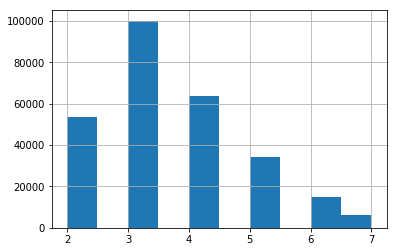

In [10]:
df['years_member'].hist()

#most people are two this data is probably older

In [12]:
for_cats_df = df.select_dtypes(include=['object'])

cats_df = create_dummy_df(df, for_cats_df.columns, False)

In [161]:
new_df = pd.concat([cats_df, channels_df], axis = 1)


df_gb = new_df.groupby(['user_id', 'offer_id']).agg('mean')

df_gb = df_gb.reset_index()
df_gb.head()

df_gb_time = df_gb.sort_values(by = 'time', axis = 0).reset_index(drop = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AFFE15B828>,
      dtype=object)

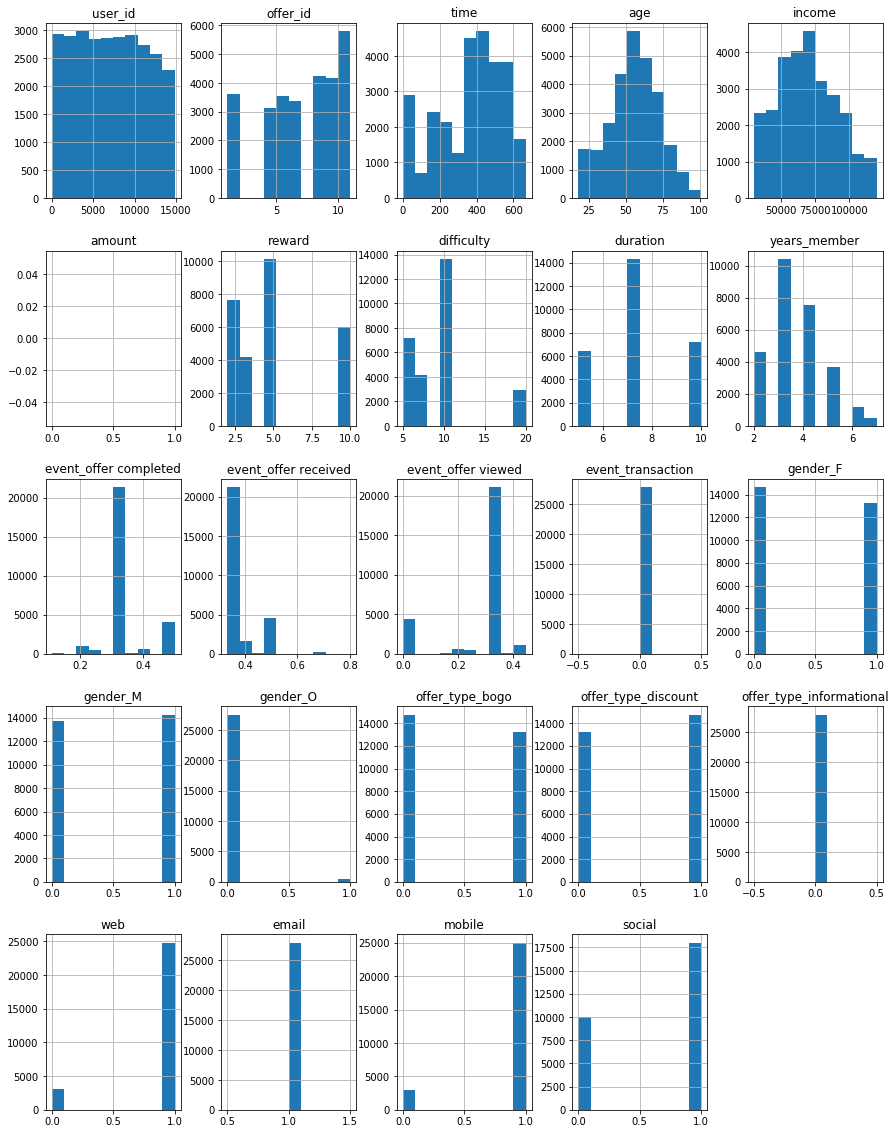

In [14]:
df_gb[df_gb['event_offer completed'] > 0].hist(figsize = (15,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AFFE6A0828>,
      dtype=object)

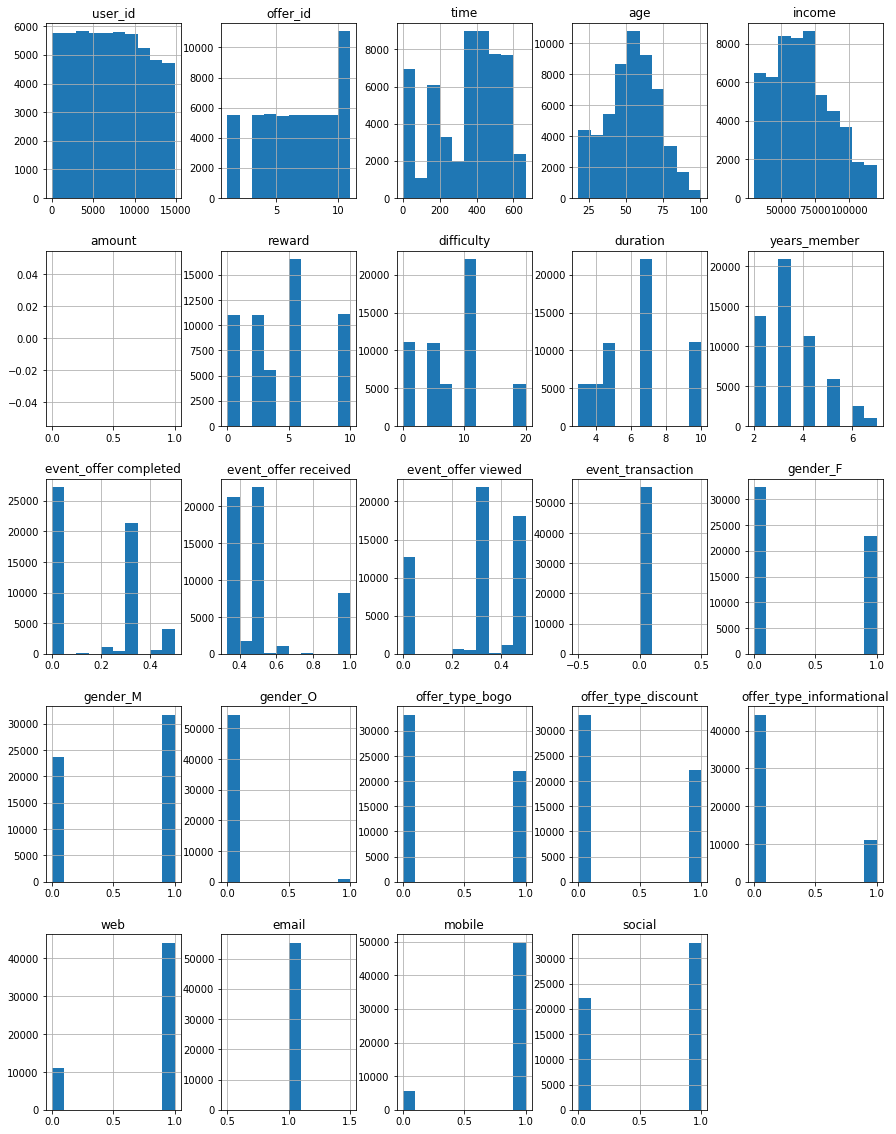

In [15]:
df_gb.hist(figsize = (15,20))

In [162]:
user_item = create_user_item_matrix(df_gb_time)

In [172]:
def clean_indices(user_item):
    user_item_2 = user_item.reset_index(drop = True)
    user_item_2 = user_item_2.T.reset_index(drop=True).T
    return(np.array(user_item_2))

In [315]:
def FunkSVD(ratings, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    ratings_np = np.array(ratings)
    n_users = ratings.shape[0]
    n_items = ratings.shape[1]
    num_ratings = (n_users)*(n_items)
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users,latent_features)
    items_mat = np.random.rand(latent_features, n_items) 
    
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    sse_totals = []
    for i in range(0, iters):
        old_sse = sse_accum
        sse_accum = 0
        for n in range(n_users): 
            for m in range(n_items):
                # if the rating exists
                
                if math.isnan(ratings_np[n,m]) == False: 
                    
                    error =  ratings_np[n, m] - np.dot(user_mat[n, :], items_mat[:, m])
                    sse_accum += error**2
                    # update the values in each matrix in the direction of the gradient
                    for x in range(latent_features):
                        
                        user_mat[n, x] += (learning_rate*(2*error*items_mat[x,m]))
                        items_mat[x, m] += (learning_rate*(2*error* user_mat[n, x]))
                        
        
        # print results for iteration
        sse_totals.append(sse_accum/m)
        #print(i + 1, sse_accum/m)
    user_mat = pd.DataFrame(user_mat)
    user_mat.index = ratings.index
    items_mat = pd.DataFrame(items_mat)
    items_mat.columns = ratings.columns
    print(iters, sse_accum/m)
    return user_mat, items_mat, sse_totals

No handles with labels found to put in legend.


Optimization Statistics
Iterations | Mean Squared Error 
1 1269.6633258967545
2 1215.2717568517035
3 1185.5344682808484
4 1156.5797329653865
5 1128.41582518584
6 1101.0474576240354
7 1074.4760548048453
8 1048.700018795965
9 1023.7150062329448
10 999.5142104502421
11 976.088642950228
12 953.4274090257936
13 931.5179730413979
14 910.346409636524
15 889.8976379121801
16 870.1556364631294
17 851.1036378954204
18 832.7243021949524
19 814.999868965016
20 797.9122891143844
21 781.443337039896
22 765.5747047049131
23 750.2880792677273
24 735.5652060674133
25 721.3879388382497
26 707.7382790111265
27 694.5984058846622
28 681.9506993260426
29 669.7777565067094
30 658.0624040043735
31 646.7877064215256
32 635.9369724927287
33 625.4937594833564
34 615.4418765275026
35 605.7653874145022
36 596.4486132121604
37 587.476135011805
38 578.832796992689
39 570.5037099306813
40 562.4742552171704
41 554.7300894051536
42 547.257149262505
43 540.0416572819883
44 533.0701275768017
45 526.3293720751508
46 519.8

369 10.48145437059146
370 10.405127587858296
371 10.32963690999292
372 10.254971959718505
373 10.181122492304294
374 10.108078393941723
375 10.035829680139548
376 9.964366494132939
377 9.893679105307891
378 9.823757907641864
379 9.754593418160063
380 9.6861762754055
381 9.618497237925174
382 9.551547182771934
383 9.485317104018785
384 9.419798111292168
385 9.354981428315151
386 9.290858391469408
387 9.227420448370918
388 9.164659156458594
389 9.102566181600373
390 9.041133296710694
391 8.980352380386883
392 8.920215415555345
393 8.860714488136182
394 8.80184178571975
395 8.743589596259627
396 8.68595030677833
397 8.628916402088619
398 8.572480463529013
399 8.516635167713096
400 8.461373285293385
401 8.406687679740335
402 8.35257130613387
403 8.299017209970465
404 8.246018525983924
405 8.193568476980055
406 8.141660372685362
407 8.090287608609728
408 8.039443664923288
409 7.989122105346549
410 7.939316576054663
411 7.890020804594864
412 7.841228598817862
413 7.792933845822912
414 7.7451

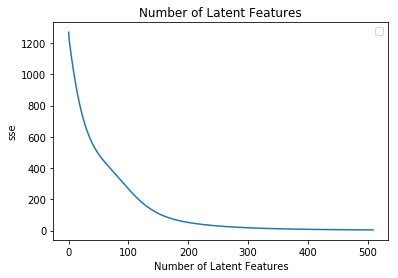

In [159]:
import matplotlib.pyplot as plt
np.random.seed(8)
plt.figure()
plt.xlabel('Number of Latent Features')
plt.ylabel('sse')
plt.title('Number of Latent Features')
plt.legend()

iters_ = 510
user_mat, offer_mat, sse = FunkSVD(user_item_2, latent_features=5, learning_rate=.01, iters=iters_) # use your function with 4 latent features, lr of 0.005 and 10 iterations
print(sse)
plt.plot(range(iters_), sse, label=str(i) + ' latent factors')
    


In [169]:



def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts


In [329]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

def latent_feature_pred(ui_train, ui_test, iters_, lf):
    '''
    INPUT: train mat, test mat, list of latent factor sizes
    
    OUTPUT: acc test, all
    
    STEPS:
        1. Creates SVD decomposition (Tries twice)
        2. subsets by number of latent factors
        3. finds dot product
        4. subsets test predictions
        5. gets test and pred accuracy
    
    '''
    
    u, vt, sse = FunkSVD(ui_train, latent_features=lf, learning_rate=.01, iters=iters_)

    
    test_ind = ui_test.index
    row_ind = ui_train.index.isin(test_ind)  
    
    test_cols = ui_test.columns
    col_ind = ui_train.columns.isin(test_cols)
    
    train_ind = ui_train.index
    row_ind_train = ui_test.index.isin(train_ind)
    ui_test_short = (ui_test.loc[row_ind_train])
    
    u_test = u.loc[row_ind]
    vt_test = vt.loc[:, vt.columns.isin(test_cols)]

    test_sse_accum = 0
    
    for n in ui_test_short.index: 
       # print(n)
        for m in ui_test_short.columns:
                # if the rating exists
          #  print(m)
            if math.isnan(ui_test_short.loc[n,m]) == False: 
                
                error =  ui_test_short.loc[n, m] - np.dot(u_test.loc[n, :], vt_test.loc[:, m])
                test_sse_accum += error**2
                    # update the values in each matrix in the direction of the gradient
  
    
      
    
    return test_sse_accum/m, sse[len(sse)-1]
        

    

In [239]:
df_gb_time.shape

(55222, 25)

In [170]:
df_train = df_gb_time.head(int(np.rint(df_gb_time.shape[0]*.7)))
df_test = df_gb_time.tail(int(np.rint(df_gb_time.shape[0]*.3)))
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

C:\Users\madke\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [335]:
def test_different_lf(lf):
    for i in range(10, 80, 20):
        sse_test, sse_all = latent_feature_pred(user_item_train, user_item_test, i, lf)
        sse_test_ls.append(sse_test)
        print(sse_test)
        sse_all_ls.append(sse_all)
    return(sse_test_ls, sse_all_ls)

In [336]:
sse_tests = []
sse_alls = []
latent_factors = []

for i in range(3, 11, 3):
    sse_test_ls, sse_all_ls = test_different_lf(i)
    sse_tests.append(sse_test_ls)
    sse_alls.append(sse_all_ls)
    latent_factors.append(i)

Optimization Statistics
Iterations | Mean Squared Error 
10 679.0822695588777
280.8914681459119
Optimization Statistics
Iterations | Mean Squared Error 
30 408.95435103641546
235.45386372432424
Optimization Statistics
Iterations | Mean Squared Error 
50 301.4079384899991
240.6998345493036
Optimization Statistics
Iterations | Mean Squared Error 
70 243.51500170877682
248.6609174542399
Optimization Statistics
Iterations | Mean Squared Error 
10 729.208597950338
279.5206539399393
Optimization Statistics
Iterations | Mean Squared Error 
30 511.61927837571824
251.74989580095504
Optimization Statistics
Iterations | Mean Squared Error 
50 377.00941509258473
253.29112540075567
Optimization Statistics
Iterations | Mean Squared Error 
70 204.45720462724802
276.33363682015437
Optimization Statistics
Iterations | Mean Squared Error 
10 754.3382472527309
282.1285312694859
Optimization Statistics
Iterations | Mean Squared Error 
30 533.147267015122
271.55502013148833
Optimization Statistics
Iteratio

In [321]:
def plot_sse_fig(iters_ls, met_all_ls, met_test_ls, met_label = "SSE"): 
    '''
    INPUT: list of latent factor vals, list of all/test accuracies, label for graphs
    
    OUTPUT: none, plots figures
    '''
    plt.figure()
    plt.plot(iters_ls, met_all_ls, label='All ' + met_label)
    plt.plot(iters_ls, met_test_ls, label='Test')
    plt.xlabel('Number of Iterations')
    plt.ylabel(met_label)
    plt.title(met_label + ' vs. Iterations')
    plt.legend()
    plt.show()

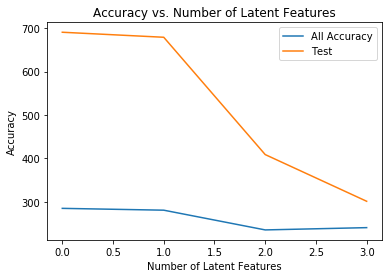

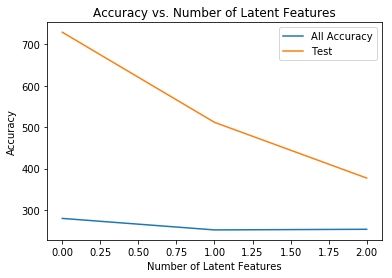

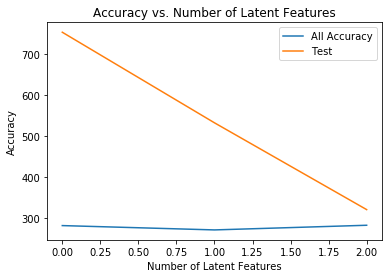

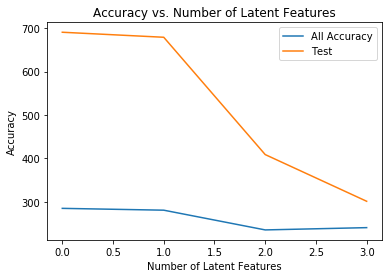

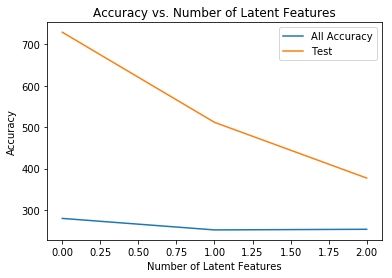

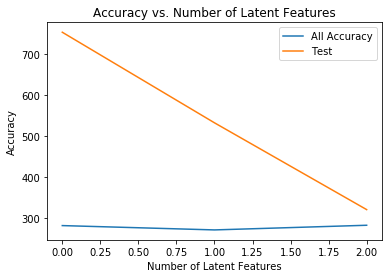

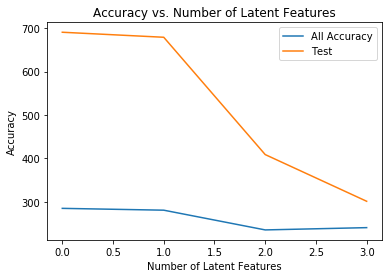

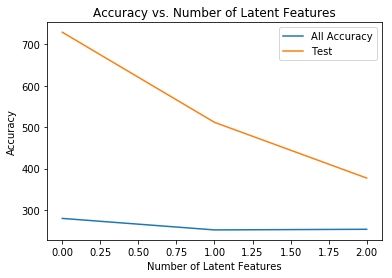

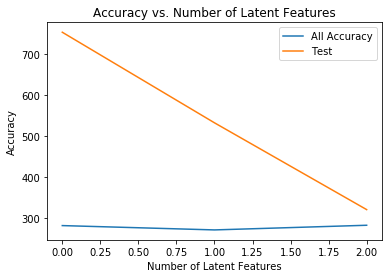

In [353]:
for i, j in enumerate(sse_tests):
    test_1 = j[0:4]
    test_2 = j[5:8]
    test_3 = j[9:len(j) - 1]
    
    all_1 = sse_alls[i][0:4]
    all_2 = sse_alls[i][5:8]
    all_3 = sse_alls[i][9:len(j) - 1]
    
    graph1 = [test_1, test_2, test_3]
    graph2 = [all_1, all_2, all_3]
    graphs = zip(graph1, graph2)
    
    for i in graphs:
        plot_sse_fig(range(len(i[0])), i[0], i[1])


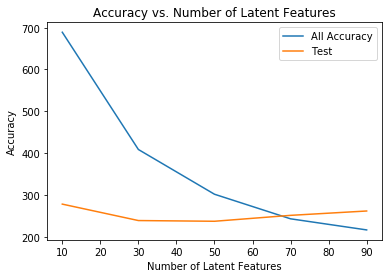

In [328]:
plot_sse_fig(range(10, 100, 20), sse_all_ls_3, sse_test_ls_3)
